In [1]:
#import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import r2_score
import cv2
import os

In [2]:
#getting the path to the folder 
dir=os.getcwd()

In [3]:
#paths to data 
albedo=dir+"/DATA/Data_Albedo/Albedo_Map.csv"
LPFe_Map=dir+"/DATA/Data_Albedo/LPFe_Map.csv"
LPK_Map=dir+"/DATA/Data_Albedo/LPK_Map.csv"
LPTh_Map=dir+"/DATA/Data_Albedo/LPTh_Map.csv"
LPTi_Map=dir+"/DATA/Data_Albedo/LPTi_Map.csv"

In [4]:
#custom dataset for nearby pixels
class dataset_nearby_pixel(Dataset):
    def __init__(self,path_1,path_2,path_3,path_4,path_5,mode):
        self.path_1=path_1
        self.path_2=path_2
        self.path_3=path_3
        self.path_4=path_4
        self.path_5=path_5
        self.mode=mode
        #converting the data to ndarray
        self.X_1=np.array(pd.read_csv(path_1))
        self.X_2=np.array(pd.read_csv(path_2))
        self.X_3=np.array(pd.read_csv(path_3))
        self.X_4=np.array(pd.read_csv(path_4))
        self.X_5=cv2.GaussianBlur(np.array(pd.read_csv(path_5)),ksize=(0,0),sigmaX=9)
        self.X=[]
        self.Y=[]
        n,m=np.shape(self.X_5)[0],np.shape(self.X_5)[1]
        for i in range(1,n-1):
            for j in range(1,m-1):
                nearby=[]
                for chem in [self.X_1,self.X_2,self.X_3,self.X_4]:
                    for a in [-1,0,1]:
                        for b in [-1,0,1]:
                            nearby.append(chem[i+a][j+b])
                self.X.append(nearby)
                self.Y.append([self.X_5[i][j]])
        l=len(self.Y)//2
        if mode == "Train" or "train":
            self.X=np.array(self.X)[:l]
            self.Y=np.array(self.Y)[:l]
        elif mode== "Test" or "test":
            self.X=np.array(self.X)[l:]
            self.Y=np.array(self.Y)[l:]
    def __len__(self):
        self.filelength=np.shape(self.Y)[0]
        return self.filelength

    def __getitem__(self,idx):
        return torch.from_numpy(self.X[idx]),torch.from_numpy(self.Y[idx])

In [5]:
class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        # Encoder Network
        self.encoder = torch.nn.Sequential(torch.nn.Linear(36,72),
                                     torch.nn.ReLU(True),
                                     torch.nn.Linear(72,148))
        # Decoder Network
        self.decoder = torch.nn.Sequential(torch.nn.Linear(148,72),
                                     torch.nn.ReLU(True),
                                     torch.nn.Linear(72, 36),
                                     torch.nn.ReLU(True),
                                     torch.nn.Linear(36,1),
                                     torch.nn.ReLU(True))
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x


In [6]:
class train():
    def __init__(self,batch_size,epochs,lr,train_val_split,scheduler,near):
        self.batch_size=batch_size
        self.scheduler=scheduler
        self.epochs=epochs
        self.lr=lr
        self.train_val_split=train_val_split
        self.near=near
        if self.near== True:
            self.data=dataset_nearby_pixel(LPFe_Map,LPK_Map,LPTh_Map,LPTi_Map,albedo,mode="train")
            self.train_data,self.val_data=random_split(self.data,[len(self.data)-int(self.train_val_split*len(self.data)),int(self.train_val_split*len(self.data))],generator=torch.Generator().manual_seed(42))
            self.train_loader=DataLoader(self.train_data,batch_size=self.batch_size,shuffle=True)
            self.val_loader=DataLoader(self.val_data,batch_size=self.batch_size,shuffle=True)
            self.net=autoencoder()
        # else:
        #     self.data=dataset(LPFe_Map,LPK_Map,LPTh_Map,LPTi_Map,albedo,0,360)
        #     self.train_data,self.val_data=random_split(self.data,[len(self.data)-int(self.train_val_split*len(self.data)),int(self.train_val_split*len(self.data))],generator=torch.Generator().manual_seed(42))
        #     self.train_loader=DataLoader(self.train_data,batch_size=self.batch_size,shuffle=True)
        #     self.val_loader=DataLoader(self.val_data,batch_size=self.batch_size,shuffle=True)
        #     self.net=model(n_feature=4, n_hidden=4, n_output=1)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        if self.scheduler==True:
            self.sched=torch.optim.lr_scheduler.ExponentialLR(self.optimizer,gamma=0.7)
        self.loss_func = torch.nn.MSELoss() 
        self.writer = SummaryWriter()
        
    def trainer(self):
        self.net=self.net.train()
        self.net=self.net.cuda()
        for epoch in range(self.epochs):
            for input,gt in self.train_loader:
                input = input.cuda()
                gt = gt.cuda()
                gt=torch.reshape(gt,(len(gt),1))
                output = self.net(input.float())
                loss = self.loss_func(output, gt.float())
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            if self.scheduler == True:
                self.sched.step()
            print('Epoch : {},  train loss : {}'.format(epoch+1,loss.item()))
            with torch.no_grad():
                for input,gt in self.val_loader:
                    input=input.cuda()
                    gt= gt.cuda()
                    gt=torch.reshape(gt,(len(gt),1))
                    val_output = self.net(input.float())
                    val_loss = self.loss_func(val_output,gt.float())
            print('Epoch : {},  val_loss : {}'.format(epoch+1,val_loss.item()))
            self.writer.add_scalar("Loss/train", loss, epoch)
            self.writer.add_scalar("Loss/val", val_loss, epoch)
            if self.scheduler == True:
                self.writer.add_scalar("lr/epoch",self.lr,epoch)
        torch.save(self.net.state_dict(),f"albedo_autoencoder_{self.epochs}_{self.lr}_{self.batch_size}.pth")

In [7]:
train_best_near=train(batch_size=64,epochs=100,lr=0.0001,train_val_split=0.3,scheduler=False,near=True)
train_best_near.trainer()

2022-04-10 16:56:31.090501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/g0kul6/miniconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-10 16:56:31.090532: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch : 1,  train loss : 0.0878107100725174
Epoch : 1,  val_loss : 0.09150587022304535
Epoch : 2,  train loss : 0.08635705709457397
Epoch : 2,  val_loss : 0.08455988019704819
Epoch : 3,  train loss : 0.08399862796068192
Epoch : 3,  val_loss : 0.09489002823829651
Epoch : 4,  train loss : 0.08470350503921509
Epoch : 4,  val_loss : 0.0816386342048645
Epoch : 5,  train loss : 0.07871576398611069
Epoch : 5,  val_loss : 0.07830406725406647
Epoch : 6,  train loss : 0.08545029908418655
Epoch : 6,  val_loss : 0.08926884829998016
Epoch : 7,  train loss : 0.07614102959632874
Epoch : 7,  val_loss : 0.08242516964673996
Epoch : 8,  train loss : 0.001455507823266089
Epoch : 8,  val_loss : 0.0037453914992511272
Epoch : 9,  train loss : 0.002118888543918729
Epoch : 9,  val_loss : 0.0018569575622677803
Epoch : 10,  train loss : 0.000737999624107033
Epoch : 10,  val_loss : 0.0023089596070349216
Epoch : 11,  train loss : 0.0009930769447237253
Epoch : 11,  val_loss : 0.0012720798840746284
Epoch : 12,  trai

RMSE Loss on right half : 0.011029566272136759
R2 score: 0.9282636140570228


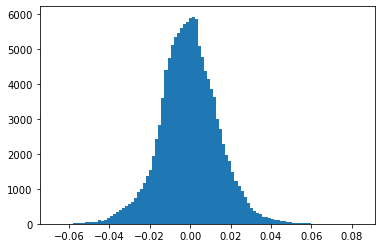

In [7]:
test_data_nearby=dataset_nearby_pixel(LPFe_Map,LPK_Map,LPTh_Map,LPTi_Map,albedo,mode="test")
test_loader_nearby=DataLoader(test_data_nearby,batch_size=1)
loss_function=torch.nn.MSELoss()
net_test=autoencoder()
net_test=net_test.cuda()
net_test.load_state_dict(torch.load(dir+"/albedo_autoencoder_100_0.0001_64.pth"))
right_predicted_near=[]
right_truth_near=[]
total_loss_near=[]
net_test=net_test.eval()
for i,l in test_loader_nearby:
    i=i.cuda()
    l=l.cuda()
    l=torch.reshape(l,(len(l),1))
    output=net_test(i.float())
    loss=loss_function(output,l.float())
    loss=loss.cpu().item()
    total_loss_near.append(np.sqrt(loss))
    right_predicted_near.append(output.cpu().item())
    right_truth_near.append(l.cpu().item())
    

print("RMSE Loss on right half :",np.mean(total_loss_near))
print("R2 score:",r2_score(right_truth_near,right_predicted_near))
residual_near=np.subtract(right_predicted_near,right_truth_near)
plt.hist(residual_near,bins=100)
plt.show()

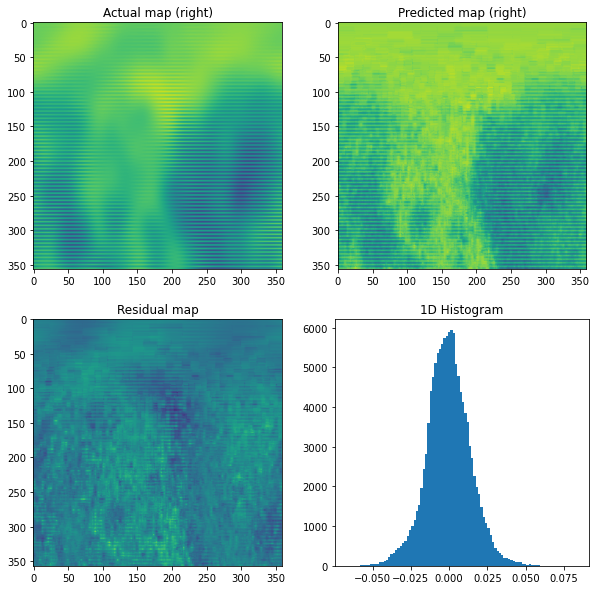

In [10]:
ffig, faxes = plt.subplots(2, 2, figsize=(10, 10))
faxes[0, 0].imshow(np.reshape(right_truth_near,(357,359)))
faxes[0, 0].set_title("Actual map (right)")
faxes[0, 0].grid(False)

faxes[0, 1].imshow(np.reshape(right_predicted_near,(357,359)))
faxes[0, 1].set_title("Predicted map (right)")
faxes[0, 1].grid(False)

faxes[1, 0].imshow(np.reshape(residual_near,(357,359)))
faxes[1, 0].set_title("Residual map")
faxes[1, 0].grid(False)

faxes[1, 1].hist(residual_near, bins=100)
faxes[1, 1].set_title("1D Histogram")
faxes[1, 1].grid(False)